In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.linalg import expm
from datetime import datetime
import time


In [4]:

# Use the widget backend for matplotlib
#%matplotlib widget

In [5]:

def cheb(N):
    if N == 0:
        return 0, 1

    # Chebyshev nodes
    x = np.cos(np.pi * np.arange(N+1) / N)

    # Coefficients for the Chebyshev differentiation matrix
    c = np.concatenate(([2], np.ones(N-1), [2])) * (-1)**np.arange(N+1)
    #print(f"c: {c}")
    
    
    # Create the difference matrix
    X = np.tile(x, (N+1, 1)).T
    dX = X - X.T

    # Construct the Chebyshev differentiation matrix
    D = np.outer(c, 1/c) / (dX + np.eye(N+1))  # Off-diagonal entries
    D = D - np.diag(np.sum(D, axis=1))  # Diagonal entries

    return D, x


In [6]:

# Parameters
N = 20
D, x = cheb(N)
x = x[1:N]                 # MATLAB: x = x(2:N)

# Initial condition
w = 0.53*x + 0.47*np.sin(-1.5*np.pi*x) - x
u = np.concatenate(([1], w + x, [-1]))

# Precompute ETDRK4 quantities
h = 1/4
M = 32

r = 15 * np.exp(1j * np.pi * (np.arange(1, M+1) - 0.5) / M)

L = D @ D
L = 0.01 * L[1:N, 1:N]

A = h * L
E = expm(A)
E2 = expm(A / 2)

I = np.eye(N-1)
Z = np.zeros((N-1, N-1))

f1 = Z.copy()
f2 = Z.copy()
f3 = Z.copy()
Q  = Z.copy()

for j in range(M):
    z = r[j]
    zIA = np.linalg.inv(z * I - A)

    Q  = Q + h * zIA * (np.exp(z/2) - 1)
    f1 = f1 + h * zIA * (-4 - z + np.exp(z)*(4 - 3*z + z**2)) / z**2
    f2 = f2 + h * zIA * (2 + z + np.exp(z)*(z - 2)) / z**2
    f3 = f3 + h * zIA * (-4 - 3*z - z**2 + np.exp(z)*(4 - z)) / z**2

Q  = np.real(Q)/M
f1 = np.real(f1)/M
f2 = np.real(f2)/M
f3 = np.real(f3)/M

# Main time-stepping loop
uu = u.reshape(-1, 1)
tt = np.array([0.0])

tmax = 70
nmax = round(tmax / h)
nplt = int(np.floor((tmax / 70) / h))

for n in range(1, nmax + 1):
    t = n * h

    Nu = (w + x) - (w + x)**3
    a  = E2 @ w + Q @ Nu
    Na = a + x - (a + x)**3

    b  = E2 @ w + Q @ Na
    Nb = b + x - (b + x)**3

    c  = E2 @ a + Q @ (2*Nb - Nu)
    Nc = c + x - (c + x)**3

    w = E @ w + f1 @ Nu + 2*f2 @ (Na + Nb) + f3 @ Nc

    if n % nplt == 0:
        u = np.concatenate(([1], w + x, [-1]))
        uu = np.hstack((uu, u.reshape(-1, 1)))
        tt = np.append(tt, t)


In [7]:
def ETD_AC(N,h):
    time_start = time.time()
    
    
    # Parameters
    #N = 2**6
    D, x = cheb(N)
    #print(x)
    x = x[1:N]                 # MATLAB: x = x(2:N)
    #print(x)
    
    # Initial condition
    w = 0.53*x + 0.47*np.sin(-1.5*np.pi*x) - x
    u = np.concatenate(([1], w + x, [-1]))

    # Precompute ETDRK4 quantities
    #h = 1/4
    M = 32

    r = 15 * np.exp(1j * np.pi * (np.arange(1, M+1) - 0.5) / M)

    L = D @ D
    L = 0.01 * L[1:N, 1:N]

    A = h * L
    E = expm(A)
    E2 = expm(A / 2)

    I = np.eye(N-1)
    Z = np.zeros((N-1, N-1))

    f1 = Z.copy()
    f2 = Z.copy()
    f3 = Z.copy()
    Q  = Z.copy()

    for j in range(M):
        z = r[j]
        zIA = np.linalg.inv(z * I - A)

        Q  = Q + h * zIA * (np.exp(z/2) - 1)
        f1 = f1 + h * zIA * (-4 - z + np.exp(z)*(4 - 3*z + z**2)) / z**2
        f2 = f2 + h * zIA * (2 + z + np.exp(z)*(z - 2)) / z**2
        f3 = f3 + h * zIA * (-4 - 3*z - z**2 + np.exp(z)*(4 - z)) / z**2

    Q  = np.real(Q)/M
    f1 = np.real(f1)/M
    f2 = np.real(f2)/M
    f3 = np.real(f3)/M

    # Main time-stepping loop
    uu = u.reshape(-1, 1)
    tt = np.array([0.0])

    tmax = 70
    nmax = round(tmax / h)
    nplt = int(np.floor((tmax / 20) / h))

    for n in range(1, nmax + 1):
        print("n = ", n)
        t = n * h

        Nu = (w + x) - (w + x)**3
        a  = E2 @ w + Q @ Nu
        Na = a + x - (a + x)**3

        b  = E2 @ w + Q @ Na
        Nb = b + x - (b + x)**3

        c  = E2 @ a + Q @ (2*Nb - Nu)
        Nc = c + x - (c + x)**3

        w = E @ w + f1 @ Nu + 2*f2 @ (Na + Nb) + f3 @ Nc

        if n % nplt == 0:
            print("Saving at t = ", t)
            u = np.concatenate(([1], w + x, [-1]))
            uu = np.hstack((uu, u.reshape(-1, 1)))
            tt = np.append(tt, t)
            
    time_end = time.time()
    time_elapsed = time_end - time_start
    print(f"ETD_AC execution time: {time_elapsed} seconds")
            
    return [x, uu, tt, time_elapsed]

In [8]:
2**6

64

In [9]:
x, uu, tt,time_elapsed = ETD_AC(64, 1)
#plt.plot(np.diff(x))

n =  1
n =  2
n =  3
Saving at t =  3
n =  4
n =  5
n =  6
Saving at t =  6
n =  7
n =  8
n =  9
Saving at t =  9
n =  10
n =  11
n =  12
Saving at t =  12
n =  13
n =  14
n =  15
Saving at t =  15
n =  16
n =  17
n =  18
Saving at t =  18
n =  19
n =  20
n =  21
Saving at t =  21
n =  22
n =  23
n =  24
Saving at t =  24
n =  25
n =  26
n =  27
Saving at t =  27
n =  28
n =  29
n =  30
Saving at t =  30
n =  31
n =  32
n =  33
Saving at t =  33
n =  34
n =  35
n =  36
Saving at t =  36
n =  37
n =  38
n =  39
Saving at t =  39
n =  40
n =  41
n =  42
Saving at t =  42
n =  43
n =  44
n =  45
Saving at t =  45
n =  46
n =  47
n =  48
Saving at t =  48
n =  49
n =  50
n =  51
Saving at t =  51
n =  52
n =  53
n =  54
Saving at t =  54
n =  55
n =  56
n =  57
Saving at t =  57
n =  58
n =  59
n =  60
Saving at t =  60
n =  61
n =  62
n =  63
Saving at t =  63
n =  64
n =  65
n =  66
Saving at t =  66
n =  67
n =  68
n =  69
Saving at t =  69
n =  70
ETD_AC execution time: 0.0297651290893

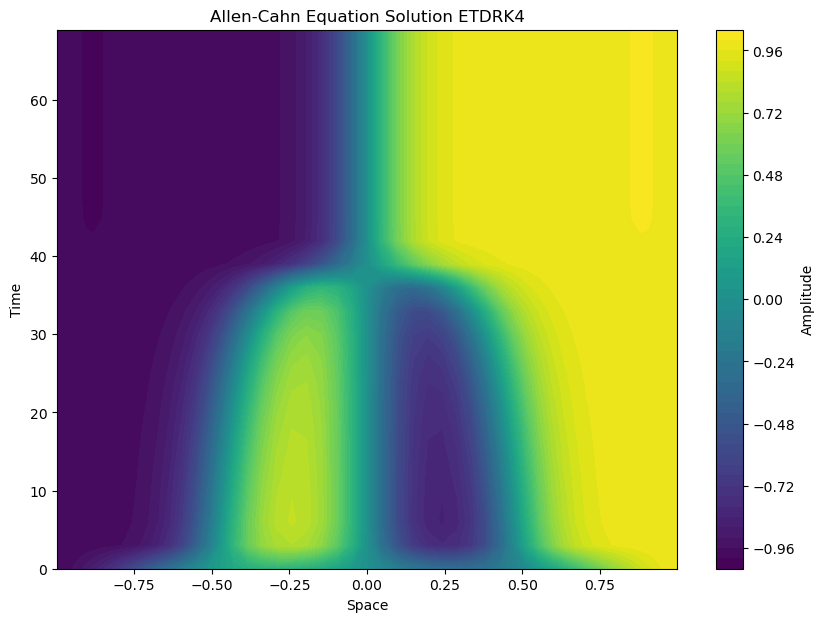

In [10]:
# Plot results using a contour plot
fig, ax = plt.subplots(figsize=(10, 7))
X, T = np.meshgrid(x, tt, indexing='ij')  # Ensure consistent indexing
contour = ax.contourf(X,T, uu[1:-1,:], levels=50, cmap=cm.viridis)  # Swap X and T to match uu's shape

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Amplitude')

# Set labels and title
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_title('Allen-Cahn Equation Solution ETDRK4')

plt.show()


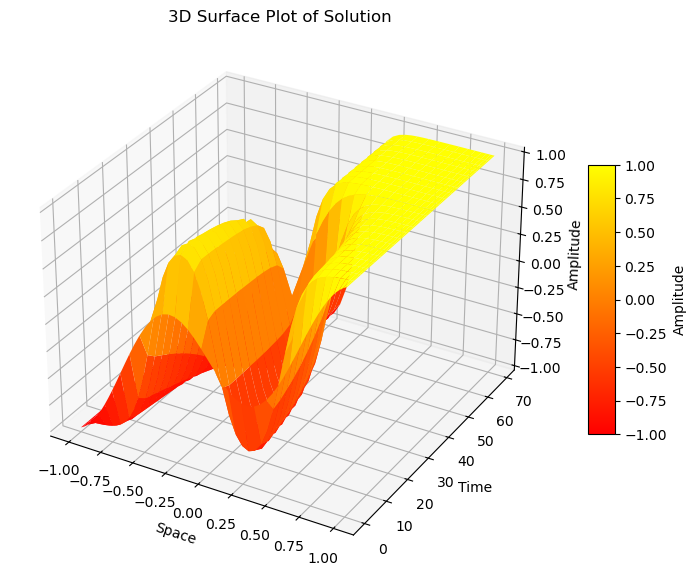

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider

# Create a figure and a 3D axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for the x and t values
X, T = np.meshgrid(x, tt, indexing='ij')

# Plot the surface
surf = ax.plot_surface(X, T, uu[1:-1, :], cmap=cm.autumn, edgecolor='none')

# Add a colorbar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Amplitude')

# Set labels and title
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('Amplitude')
ax.set_title('3D Surface Plot of Solution')
# Add sliders for adjusting the viewing angle


plt.show()

ValueError: x and y must have same first dimension, but have shapes (63,) and (19,)

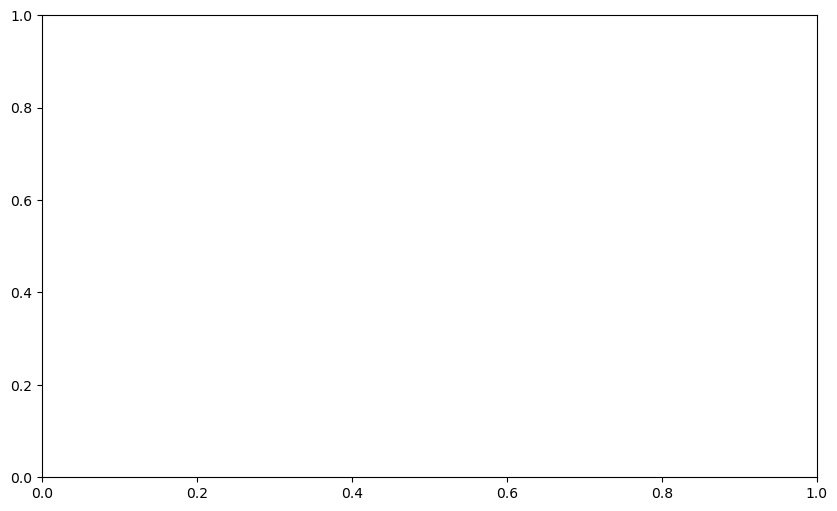

In [12]:
from matplotlib.animation import FuncAnimation, PillowWriter

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot(x, uu[1:N,0], color='blue')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(uu.min(), uu.max())
ax.set_xlabel('Space')
ax.set_ylabel('Amplitude')
ax.set_title('Allen-Cahn EQ Solution Over Time')
def update(frame):
    line.set_ydata(uu[1:N,frame])
    ax.set_title(f'Allen-Cahn EQ Solution Over Time (t = {tt[frame]/20:.2f})')
    return line,
# Create the animation
ani = FuncAnimation(fig, update, frames=len(tt), interval=50, blit=True)

# Save the animation as a GIF file
ani.save('AC_eq.gif', writer=PillowWriter(fps=20))

plt.close(fig)

In [ ]:
# def EM_AC(h,mu):
#     ## h is our time step
#     ## mu is a coefficient relating time step to spatial step
#     ## mu = epsilon*h/dX**2
    
#     dX = np.sqrt(0.1* h / mu)
    
    
#     ## I know that I want my spatial dimension to be [-1,1] but dX does not necessarily divide that evenly.
#     ## so I need to find the closest number of points that will work.
#     N = np.ceil(2/dX) + 1
#     dX = 2/(N-1)
    
#     ## This approximates dX to the smaller value that will fit evenly into [-1,1]
#     x = np.linspace(-1,1,int(N))
    
#     ## Initial condition
#     u = 0.53*x + 0.47*np.sin(-1.5*np.pi*x)
#     u[0] = -1
#     u[-1] = 1
#     uu = u.reshape(-1,1)
#     tt = np.array([0.0])
    
    
#     tmax = 70
#     nmax = round(tmax / h)
#     nplt = int(np.floor((tmax / 70) / h))
#     for i in range(nmax):
#         t = i * h
        
#         u_new = u.copy()
#         for j in range(1,len(x)-1):
#             u_new[j] = u[j] + h*(0.1*(u[j+1]-2*u[j]+u[j-1])/dX**2 + u[j] - u[j]**3)
#         u = u_new.copy()
        
#         if i % nplt == 0:
#             tt = np.append(tt, t)
#             uu = np.hstack((uu, u.reshape(-1, 1)))
            
#             print(f"saving at t: {i*h}")
            
#     return [x, uu, tt]
    
    
    
    

In [ ]:
np.linspace(-1,1,11)



array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [ ]:
def EM_AC(dx,mu):
    
    
    tmax = 70
    d = int(np.ceil(2/dx))+1
    dx = 2/(d-1)
    dt = mu * (dx**2)
    print(dt,d,dx)
    ## dt does not necessarily divide tmax evenly
    ## I want to finish at tmax so I need to adjust dt slightly
    
    nmax = int(np.ceil(tmax / dt))
    dt = tmax / nmax
    nplt = int(np.floor((tmax / 70) / dt))
    print(dt,nmax,nplt)
    
    x = np.linspace(-1,1,d)
    print(x)
    #t = np.arange(tmax+1)*dt
    ##initial conditions
    u = 0.53*x + 0.47*np.sin(-1.5*np.pi*x)
    u[0] = -1
    u[-1] = 1
    #print(u)
    
    
    uu = u.copy()
    #print(uu)
    t = np.array([0.0])
    
    for n in range(nmax+1):
        unew = u.copy()
        unew[1:-1] = u[1:-1] + mu*(0.01*(u[2:] - 2*u[1:-1] + u[:-2]) + (dx**2)*(u[1:-1] - u[1:-1]**3))
        
        u = unew.copy()
        if n % nplt == 0:
            print(f"saving at t: {n*dt}")
            uu = np.vstack((uu, u))
            t = np.append(t, n*dt)
            print(t.shape)
        #u[1:-1,n+1] = u[1:-1,n] + mu*(u[2:,n] - 2*u[1:-1,n] + u[:-2,n] + dx**2*(u[1:-1,n] - u[1:-1,n]**3)
        
        
    return x, t, uu
    

In [ ]:
(25*(1/10)**2)

0.25000000000000006

In [ ]:
25*((1/10)**2)

0.25000000000000006

In [ ]:
x, t, uu = EM_AC(1/10, 40)

0.4000000000000001 21 0.1
0.4 175 2
[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
saving at t: 0.0
(2,)
saving at t: 0.8
(3,)
saving at t: 1.6
(4,)
saving at t: 2.4000000000000004
(5,)
saving at t: 3.2
(6,)
saving at t: 4.0
(7,)
saving at t: 4.800000000000001
(8,)
saving at t: 5.6000000000000005
(9,)
saving at t: 6.4
(10,)
saving at t: 7.2
(11,)
saving at t: 8.0
(12,)
saving at t: 8.8
(13,)
saving at t: 9.600000000000001
(14,)
saving at t: 10.4
(15,)
saving at t: 11.200000000000001
(16,)
saving at t: 12.0
(17,)
saving at t: 12.8
(18,)
saving at t: 13.600000000000001
(19,)
saving at t: 14.4
(20,)
saving at t: 15.200000000000001
(21,)
saving at t: 16.0
(22,)
saving at t: 16.8
(23,)
saving at t: 17.6
(24,)
saving at t: 18.400000000000002
(25,)
saving at t: 19.200000000000003
(26,)
saving at t: 20.0
(27,)
saving at t: 20.8
(28,)
saving at t: 21.6
(29,)
saving at t: 22.400000000000002
(30,)
saving at t: 23.200000000000003
(31,)
s

Text(0.5, 1.0, 'Allen-Cahn Equation Solution FDM')

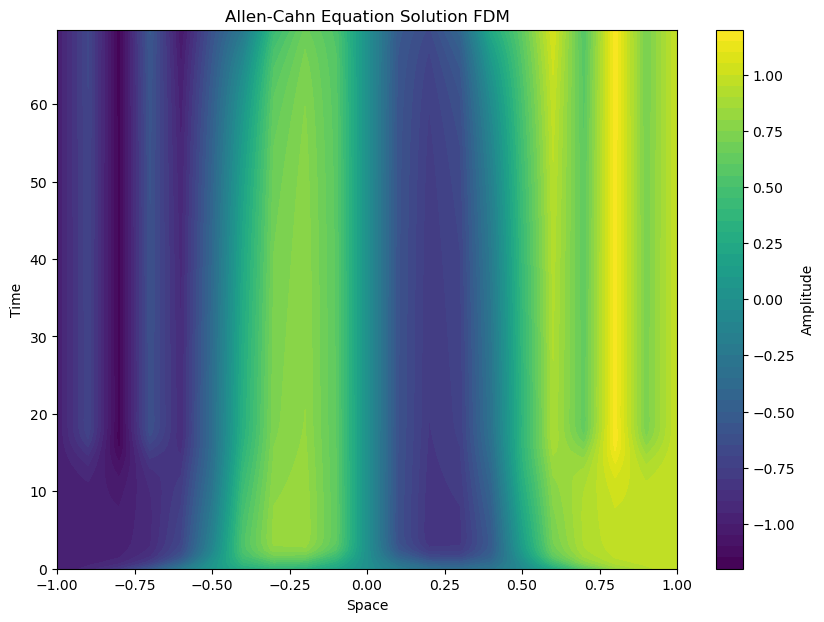

In [ ]:
##plotting the euler method results:
# fig = plt.figure(figsize = (4,6))
# c = plt.pcolormesh(x, t, uu)
# fig.colorbar(c)


##plot as a contour plot
fig, ax = plt.subplots(figsize=(10, 7))
X, T = np.meshgrid(x, t, indexing='ij')  # Ensure consistent indexing
contour = ax.contourf(X,T, uu.T[:,:], levels=50, cmap=cm.viridis)  # Swap X and T to match uu's shape
# Add a colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Amplitude')
# Set labels and title
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_title('Allen-Cahn Equation Solution FDM')

In [ ]:
uu.shape

(89, 21)

In [ ]:
X.shape

(21, 89)

In [ ]:
##creating a gif of the euler method solution
from matplotlib.animation import FuncAnimation, PillowWriter
# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot(x, uu[0,:], color='blue')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(uu.min(), uu.max())
ax.set_xlabel('Space')
ax.set_ylabel('Amplitude')
ax.set_title('Allen-Cahn EQ Solution Over Time using FD Method')
def update(frame):
    line.set_ydata(uu[frame,:])
    ax.set_title(f'Allen-Cahn EQ Solution Over Time (t = {t[frame]:.2f})')
    return line,
# Create the animation
ani = FuncAnimation(fig, update, frames=len(t), interval=50, blit=True)
# Save the animation as a GIF file
ani.save('AC_eq_FD.gif', writer=PillowWriter(fps=20))
plt.close(fig)

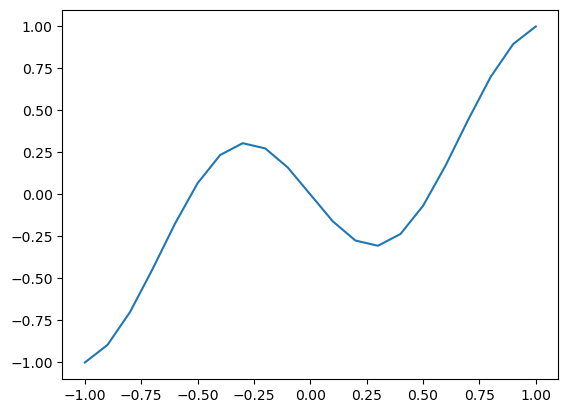

In [ ]:
plt.plot(x,uu[0,:])